# Machine Learning Final Project

## Zhixing Sun

A Brain tumor is considered as one of the aggressive diseases, among children and adults. Brain tumors account for 85 to 90 percent of all primary Central Nervous System(CNS) tumors. Every year, around 11,700 people are diagnosed with a brain tumor. The 5-year survival rate for people with a cancerous brain or CNS tumor is approximately 34 percent for men and36 percent for women. Brain Tumors are classified as: Benign Tumor, Malignant Tumor, Pituitary Tumor, etc. Proper treatment, planning, and accurate diagnostics should be implemented to improve the life expectancy of the patients. The best technique to detect brain tumors is Magnetic Resonance Imaging (MRI). A huge amount of image data is generated through the scans. These images are examined by the radiologist. A manual examination can be error-prone due to the level of complexities involved in brain tumors and their properties.

Often times in developing countries the lack of skillful doctors and lack of knowledge about tumors makes it really challenging and time-consuming to generate reports from MRI’. So an automated system on Cloud can solve this problem. I'm trying to implement Deep Learning Algorithms using ConvolutionNeural Network (CNN) and TransferLearning (TL) to perform detection and classification of brain tumor, the dataset I'm used for training is https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

### Import packages and check environment for colab


In [125]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow, imread
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils import to_categorical
from keras.applications import MobileNet, MobileNetV2, VGG16, EfficientNetB0, ResNet50, EfficientNetB3
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay


In [126]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Downloaded dataset and sort the train test dataset

The folder contains MRI data. The images are already split into Training and Testing folders. Each folder has more four subfolders. These folders have MRIs of respective tumor classes. I define labels 0-3 to these four categories.

In [127]:
path = "/content/drive/MyDrive/archive"
list(os.listdir(path + "/Training"))

['meningioma_tumor', 'no_tumor', 'pituitary_tumor', 'glioma_tumor']

In [128]:
path = "/content/drive/MyDrive/archive"
list(os.listdir(path + "/Testing"))

['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

In [129]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

class_map = {
    'no_tumor': 0,
    'glioma_tumor': 1,
    'meningioma_tumor': 2,
    'pituitary_tumor': 3
}

inverse_class_map = {
    0: 'no_tumor',
    1: 'glioma_tumor',
    2: 'meningioma_tumor',
    3: 'pituitary_tumor'
}

Take a look at the size and examples of four categories of tumor

### EDA

In [130]:
img_path = '/content/drive/MyDrive/archive/Training/pituitary_tumor/p (12).jpg'
img = plt.imread(img_path)
print('Input image shape is:',img.shape)

Input image shape is: (512, 512, 3)


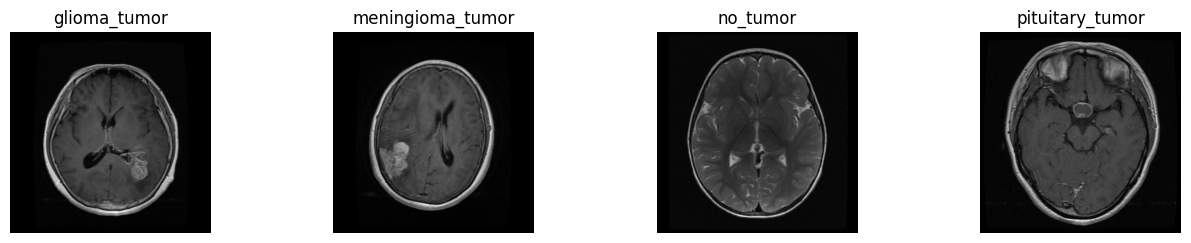

In [131]:
plt.figure(figsize=(16, 12))

path = '/content/drive/MyDrive/archive/Training/'
fileNames = ['glioma_tumor/gg (10).jpg', 'meningioma_tumor/m (108).jpg', 'no_tumor/image (16).jpg', 'pituitary_tumor/p (12).jpg']
fileLabels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

for i in range(4):
    ax = plt.subplot(4, 4, i + 1)
    img = mpimg.imread(path + fileNames[i])
    plt.imshow(img)
    plt.title(fileLabels[i])
    plt.axis("off")

Create and combine the image and label dataset

In [132]:
h, w = 224, 224
batch_size = 32
epochs = 40

In [133]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    validation_split=0.2,
    horizontal_flip = True
)

In [134]:
train_set = datagen.flow_from_directory(
    '/content/drive/MyDrive/archive/Training',
    target_size=(h, w),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'training'
)

Found 2297 images belonging to 4 classes.


In [135]:
validation_set = datagen.flow_from_directory(
    '/content/drive/MyDrive/archive/Training',
    target_size=(h, w),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'validation'
)

Found 573 images belonging to 4 classes.


In [136]:
test_set = datagen.flow_from_directory(
    '/content/drive/MyDrive/archive/Testing',
    target_size=(h, w),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 394 images belonging to 4 classes.


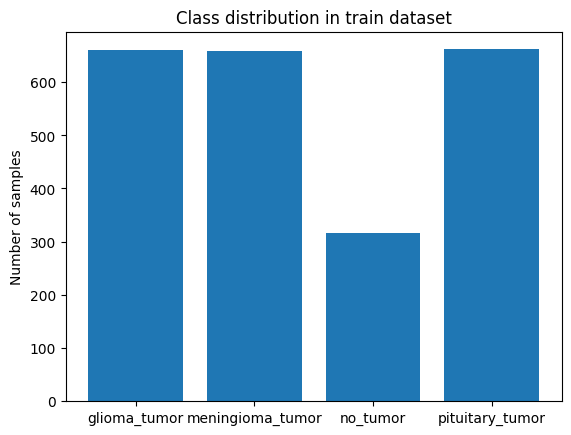

In [137]:
train_labels = train_set.labels
class_counts_train = np.bincount(train_labels)

plt.bar(range(len(class_counts_train)), class_counts_train)
plt.title('Class distribution in train dataset')
plt.xticks(range(len(class_counts_train)),train_set.class_indices.keys())
plt.ylabel('Number of samples')
plt.show()

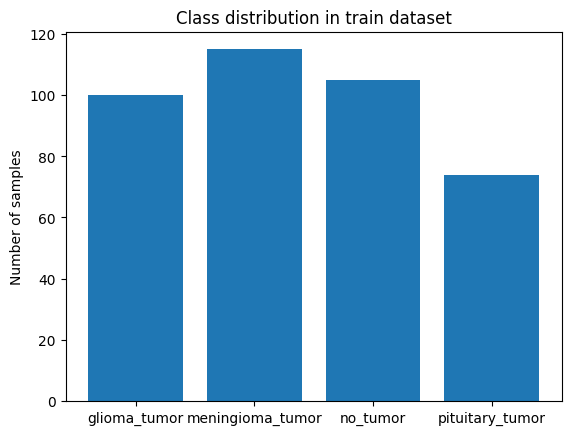

In [138]:
train_labels = test_set.labels
class_counts_train = np.bincount(train_labels)

plt.bar(range(len(class_counts_train)), class_counts_train)
plt.title('Class distribution in train dataset')
plt.xticks(range(len(class_counts_train)),test_set.class_indices.keys())
plt.ylabel('Number of samples')
plt.show()

### Model 1 with VGG16 as base model

In [33]:
base_model = VGG16(
    input_shape=(h, w, 3), 
    weights='imagenet',
    include_top=False, 
    pooling='max'
)

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
base_model.trainable = False

output_class = 4

model = Sequential([
    base_model,
    Dropout(rate=0.5),
    Dense(output_class, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 14,716,740
Trainable params: 2,052
Non-trainable params: 14,714,688
_________________________________________________________________


In [37]:
earlystop = EarlyStopping(monitor='val_loss', patience=5)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [38]:
with tf.device('/device:GPU:0'):
  history = model.fit(train_set, validation_data = validation_set, batch_size = batch_size,
                    epochs = epochs, verbose = 1, callbacks = callbacks)

Epoch 1/40
72/72 [==============================] - 50s 703ms/step - loss: 1.1354 - accuracy: 0.5155 - val_loss: 1.0574 - val_accuracy: 0.5148 - lr: 0.0010
Epoch 2/40
72/72 [==============================] - 70s 978ms/step - loss: 1.0356 - accuracy: 0.5612 - val_loss: 0.9907 - val_accuracy: 0.5620 - lr: 0.0010
Epoch 3/40
72/72 [==============================] - 53s 742ms/step - loss: 0.9361 - accuracy: 0.6034 - val_loss: 0.9370 - val_accuracy: 0.6248 - lr: 0.0010
Epoch 4/40
72/72 [==============================] - 55s 771ms/step - loss: 0.8994 - accuracy: 0.6125 - val_loss: 0.9251 - val_accuracy: 0.6248 - lr: 0.0010
Epoch 5/40
72/72 [==============================] - ETA: 0s - loss: 0.8513 - accuracy: 0.6513
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
72/72 [==============================] - 48s 667ms/step - loss: 0.8513 - accuracy: 0.6513 - val_loss: 0.9063 - val_accuracy: 0.6038 - lr: 0.0010
Epoch 6/40
72/72 [==============================] - 55s 764ms

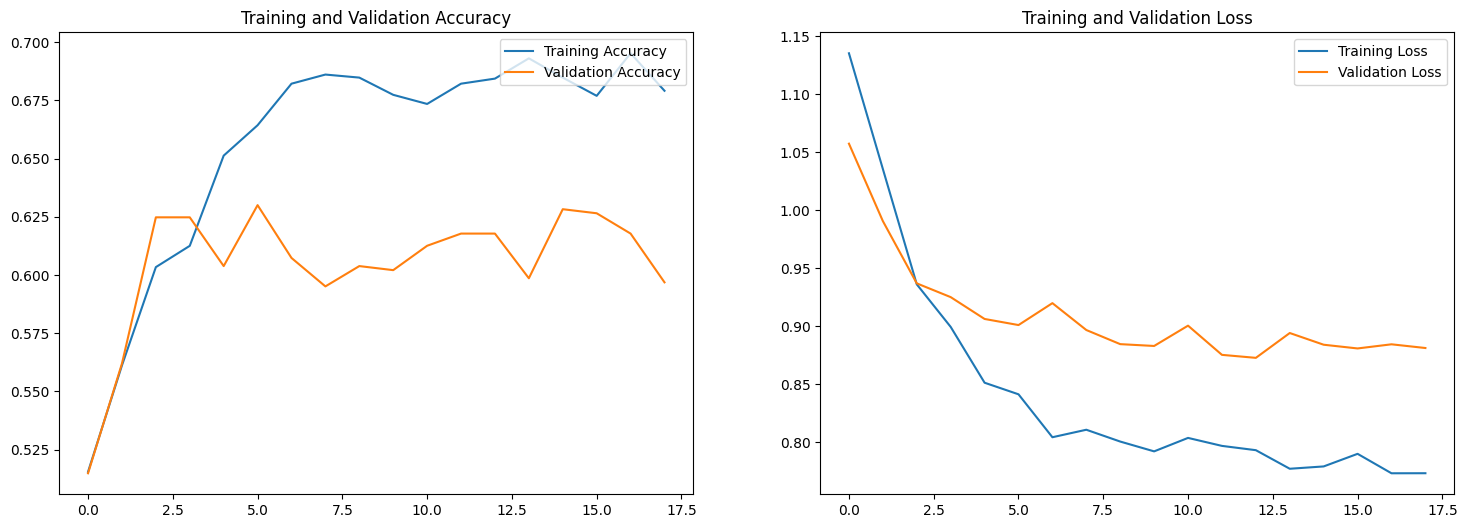

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(history.history['accuracy'])), acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
predicted_labels_1 = model.predict(test_set)
predicted_labels_1 = [np.argmax(i) for i in predicted_labels_1]

13/13 [==============================] - 80s 7s/step


In [41]:
original_labels_1 = test_set.classes

In [44]:
conf_mat_1 = confusion_matrix(original_labels_1, predicted_labels_1)
report_1 = classification_report(original_labels_1, predicted_labels_1)

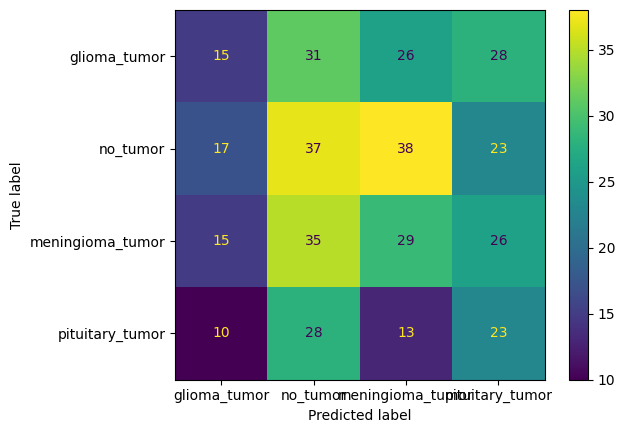

In [49]:
cm = confusion_matrix(original_labels_1, predicted_labels_1)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot()
plt.show()

In [51]:
print(conf_mat_1)
print(report_1)

[[15 31 26 28]
 [17 37 38 23]
 [15 35 29 26]
 [10 28 13 23]]
              precision    recall  f1-score   support

           0       0.26      0.15      0.19       100
           1       0.28      0.32      0.30       115
           2       0.27      0.28      0.27       105
           3       0.23      0.31      0.26        74

    accuracy                           0.26       394
   macro avg       0.26      0.26      0.26       394
weighted avg       0.27      0.26      0.26       394

